In [1]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()
from setup import setup_src_path
print(setup_src_path())
import data.processed as processed
import config.config as config
import utils.setup as setup
import utils.functions as fn
from importlib import reload



['/home/guest/Desktop/projects/third-experiments/SDA_experiments/mlm', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages', '/home/guest/Desktop/projects/third-experiments/SDA_experiments/modules']


2024-06-25 06:21:57.322246: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 06:21:57.395618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 06:21:58.234885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from datasets import load_from_disk, DatasetDict
from sklearn.model_selection import train_test_split

def load_and_prepare_datasets(source_genre, target_genre, data_fraction=0.01):
    # Load the dataset
    dataset = load_from_disk(f"{config.Config.DATASETS_SAVE_PATH}/SDA_cleaned")
    
    # Shuffle the source dataset
    filtered_source = dataset[source_genre].shuffle(seed=42)
    
    # If a fraction of the data is to be used
    if data_fraction < 1.0:
        filtered_source = filtered_source.select(range(int(len(filtered_source) * data_fraction)))
    
    # Split the source dataset into 80% train and 20% remaining
    train_size = 0.8
    source_train_dataset, source_remaining_dataset = filtered_source.train_test_split(test_size=1-train_size, seed=42).values()
     
    # Combine source splits into a DatasetDict
    source_dataset_dict = DatasetDict({
        'train': source_train_dataset,
        'val': source_remaining_dataset
    })
    
    # Shuffle the target dataset
    filtered_target = dataset[target_genre].shuffle(seed=42)
    
    # If a fraction of the data is to be used
    if data_fraction < 1.0:
        filtered_target = filtered_target.select(range(int(len(filtered_target) * data_fraction)))
    
    # Split the target dataset into 80% train and 20% remaining
    target_train_dataset, target_remaining_dataset = filtered_target.train_test_split(test_size=1-train_size, seed=42).values()
    
      
    # Combine target splits into a DatasetDict
    target_dataset_dict = DatasetDict({
        'train': target_train_dataset,
        'test': target_remaining_dataset,
    })
    
    # Print the number of examples in each split to verify
    print(f"Source Train dataset size: {len(source_dataset_dict['train'])}")
    print(f"Source Validation dataset size: {len(source_dataset_dict['val'])}")
    
    print(f"Target Train dataset size: {len(target_dataset_dict['train'])}")
    print(f"Target Test dataset size: {len(target_dataset_dict['test'])}")
    
    return source_dataset_dict, target_dataset_dict

# Example usage
source_genre = 'books'
target_genre = 'electronics'
source_dataset, target_dataset = load_and_prepare_datasets(source_genre, target_genre, data_fraction=1)


Source Train dataset size: 1600
Source Validation dataset size: 400
Target Train dataset size: 1600
Target Test dataset size: 400


In [8]:
import torch
import numpy as np
import random
from datasets import load_from_disk, concatenate_datasets
from transformers import AutoTokenizer, AutoConfig, TrainingArguments, EvalPrediction, default_data_collator, EarlyStoppingCallback, get_cosine_schedule_with_warmup
from adapters import AdapterTrainer, AutoAdapterModel, AdapterConfig, composition
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from pprint import pprint
def set_seeds(seed=42):
    print(f"===============================================")
    print(f"Setting seed to: {seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def tokenize_dataset(data, tokenizer):
    def tokenize_function(examples):
        result = tokenizer(examples['review'], truncation=True, padding='max_length', max_length=128)
        # if tokenizer.is_fast:
        #     result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
        return result

    tokenized_datasets = data.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(
        ['review']
    ).rename_column("label", "labels").with_format('torch')

    return tokenized_datasets

def prepare_model(adapter_name, mlm_adapter):
    mdlcfg = AutoConfig.from_pretrained(config.Config.MODEL_NAME)
    model = AutoAdapterModel.from_pretrained(config.Config.MODEL_NAME, config=mdlcfg)
    adapter_config = AdapterConfig.load("lora", r=8, alpha=16)

    model.add_adapter(adapter_name, config=adapter_config)
    model.load_adapter(f"{config.Config.ADAPTER_SAVE_PATH}/{mlm_adapter}", with_head=False)
    model.add_classification_head(adapter_name, num_labels=2)
    model.active_adapters = composition.Stack(mlm_adapter, adapter_name)
    model.train_adapter(composition.Stack(mlm_adapter, adapter_name))
    print(model.adapter_summary())
    fn.print_trainable_parameters(model)
    return model

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def compute_metrics(pred: EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    # Plot confusion matrix
    plot_confusion_matrix(labels, preds, classes=['class_0', 'class_1'])
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



def train_and_evaluate(project_name,seed, train_source, train_target, source_genre, target_genre, adapter_name, mlm_adapter):
    set_seeds(seed)
    
    wandb.init(project=f"{project_name}", name=f"{source_genre}_{target_genre}_run_seed_{seed}")

    tokenizer = AutoTokenizer.from_pretrained(config.Config.TOKENIZER_NAME)

    tokenized_source_dataset = tokenize_dataset(train_source, tokenizer)
    tokenized_target_dataset = tokenize_dataset(train_target, tokenizer)

    train_source, val_source = tokenized_source_dataset['train'], tokenized_source_dataset['val']
    train_target, test_target= tokenized_target_dataset['train'], tokenized_target_dataset['test']
    

    model = prepare_model(adapter_name, mlm_adapter)

    eval_data = val_source
    batch_size = 16
    logging_steps = len(train_source) // (batch_size * 2)

    training_args = TrainingArguments(
        output_dir=f"{config.Config.RESULTS_SAVE_PATH}/{adapter_name}/results",
        num_train_epochs=10,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        learning_rate=1e-4,
        weight_decay=0.01,
        logging_dir=f"{config.Config.RESULTS_SAVE_PATH}/{adapter_name}/logs",
        logging_steps=logging_steps,
        evaluation_strategy="steps",
        eval_steps=logging_steps,
        save_steps=logging_steps,
        save_total_limit=2,
        #load_best_model_at_end=True,
        #metric_for_best_model="eval_accuracy",
        #greater_is_better=True,                
        report_to="wandb"
    )

    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

    trainer = AdapterTrainer(
        model=model,
        args=training_args,
        train_dataset=train_source,
        eval_dataset=eval_data,
        #callbacks=callbacks,
        compute_metrics=compute_metrics
    )

    trainer.create_optimizer_and_scheduler(num_training_steps=len(train_source) * training_args.num_train_epochs // batch_size)
    optimizer = trainer.optimizer
    total_steps = len(train_source) * training_args.num_train_epochs // batch_size
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=training_args.warmup_steps, num_training_steps=total_steps)
    trainer.lr_scheduler = scheduler

    trainer.train()
    eval_trainer = AdapterTrainer(
        model=model,
        args=TrainingArguments(f"{config.Config.RESULTS_SAVE_PATH}/{adapter_name}/results", remove_unused_columns=False),
        eval_dataset=val_source,
        compute_metrics=compute_metrics,
    )
    eval_results = eval_trainer.evaluate()
    wandb.log({"eval_results": eval_results})
    # Evaluate on test set
    test_results = eval_trainer.evaluate(eval_dataset=test_target)
    plot_loss(trainer.state.log_history)

    #wandb.log(eval_results)
    wandb.log({"test_results": test_results})
    
    wandb.finish()

    return eval_results,test_results

def plot_loss(log_history):
    epochs_train = []
    training_losses = []
    epochs_eval = []
    evaluation_losses = []

    for record in log_history:
        if "loss" in record and "epoch" in record:
            epochs_train.append(record["epoch"])
            training_losses.append(record["loss"])
        if "eval_loss" in record and "epoch" in record:
            epochs_eval.append(record["epoch"])
            evaluation_losses.append(record["eval_loss"])

    plt.figure(figsize=(6, 3))
    plt.plot(epochs_train, training_losses, 'b', label='Training Loss')
    plt.plot(epochs_eval, evaluation_losses, 'r', label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss over Epochs')
    plt.legend()
    plt.show()


    

Source Train dataset size: 1600
Source Validation dataset size: 400
Target Train dataset size: 1600
Target Test dataset size: 400
Setting seed to: 42


eval/accuracy,▁▇█
eval/f1,▁██
eval/loss,█▆▁
eval/precision,▁▆█
eval/recall,▁▇█
eval/runtime,█▁▅
eval/samples_per_second,▁█▄
eval/steps_per_second,▁█▄
train/epoch,▁▁▅▅██
train/global_step,▁▁▅▅██
train/grad_norm,▂▁█


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
SDA_SG_invLora_stack     lora                294,912       0.269       1       1
SDA_mlm_inv_G            bottleneck        7,387,776       6.748       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8897468 || all params: 118379708 || trainable%: 7.516041516169309


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.6878, 'grad_norm': 2.5518696308135986, 'learning_rate': 1e-05, 'epoch': 0.5}


  0%|          | 0/25 [00:00<?, ?it/s]

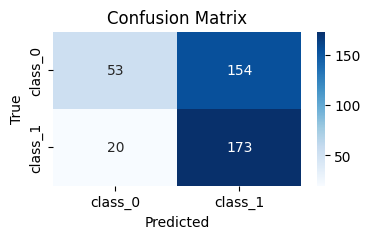

{'eval_loss': 0.6753187775611877, 'eval_accuracy': 0.565, 'eval_f1': 0.5169587912087912, 'eval_precision': 0.6309867621800511, 'eval_recall': 0.565, 'eval_runtime': 3.95, 'eval_samples_per_second': 101.265, 'eval_steps_per_second': 6.329, 'epoch': 0.5}
{'loss': 0.6603, 'grad_norm': 1.9958542585372925, 'learning_rate': 2e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

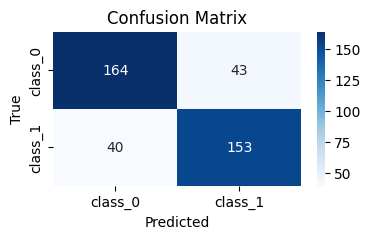

{'eval_loss': 0.5829858183860779, 'eval_accuracy': 0.7925, 'eval_f1': 0.7925428292646314, 'eval_precision': 0.7926748199279712, 'eval_recall': 0.7925, 'eval_runtime': 3.8838, 'eval_samples_per_second': 102.992, 'eval_steps_per_second': 6.437, 'epoch': 1.0}
{'loss': 0.4792, 'grad_norm': 8.48128604888916, 'learning_rate': 3e-05, 'epoch': 1.5}


  0%|          | 0/25 [00:00<?, ?it/s]

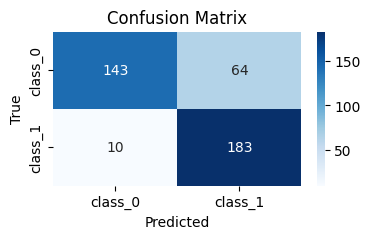

{'eval_loss': 0.40368446707725525, 'eval_accuracy': 0.815, 'eval_f1': 0.8124772727272728, 'eval_precision': 0.8411562276732556, 'eval_recall': 0.815, 'eval_runtime': 3.9683, 'eval_samples_per_second': 100.799, 'eval_steps_per_second': 6.3, 'epoch': 1.5}
{'loss': 0.3674, 'grad_norm': 3.2577590942382812, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

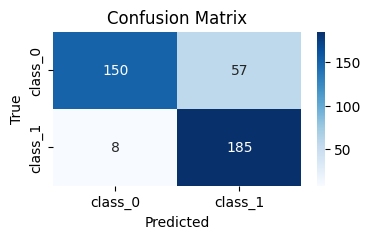

{'eval_loss': 0.37857958674430847, 'eval_accuracy': 0.8375, 'eval_f1': 0.8357447646039995, 'eval_precision': 0.8601507741395542, 'eval_recall': 0.8375, 'eval_runtime': 3.9621, 'eval_samples_per_second': 100.957, 'eval_steps_per_second': 6.31, 'epoch': 2.0}
{'loss': 0.3194, 'grad_norm': 2.874185562133789, 'learning_rate': 5e-05, 'epoch': 2.5}


  0%|          | 0/25 [00:00<?, ?it/s]

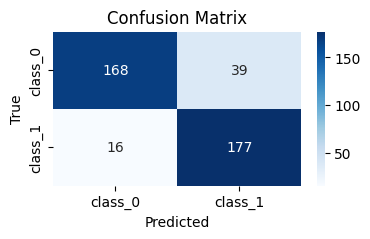

{'eval_loss': 0.3168262541294098, 'eval_accuracy': 0.8625, 'eval_f1': 0.8623220192722566, 'eval_precision': 0.8678819444444444, 'eval_recall': 0.8625, 'eval_runtime': 3.9332, 'eval_samples_per_second': 101.697, 'eval_steps_per_second': 6.356, 'epoch': 2.5}
{'loss': 0.2805, 'grad_norm': 1.7513010501861572, 'learning_rate': 6e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

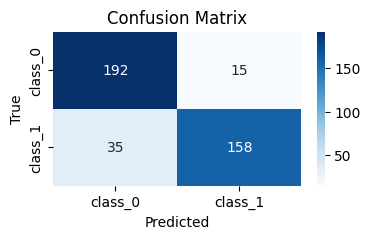

{'eval_loss': 0.30450326204299927, 'eval_accuracy': 0.875, 'eval_f1': 0.874464883785349, 'eval_precision': 0.8783739909857147, 'eval_recall': 0.875, 'eval_runtime': 3.9672, 'eval_samples_per_second': 100.827, 'eval_steps_per_second': 6.302, 'epoch': 3.0}
{'loss': 0.2414, 'grad_norm': 0.7608163952827454, 'learning_rate': 7e-05, 'epoch': 3.5}


  0%|          | 0/25 [00:00<?, ?it/s]

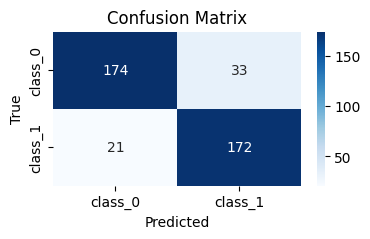

{'eval_loss': 0.36700889468193054, 'eval_accuracy': 0.865, 'eval_f1': 0.8650202505062626, 'eval_precision': 0.8665984990619137, 'eval_recall': 0.865, 'eval_runtime': 3.9682, 'eval_samples_per_second': 100.801, 'eval_steps_per_second': 6.3, 'epoch': 3.5}
{'loss': 0.295, 'grad_norm': 4.437269687652588, 'learning_rate': 8e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

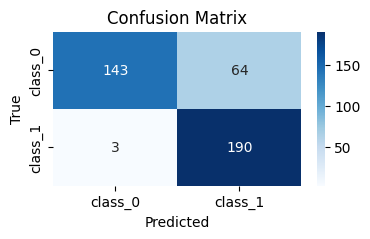

{'eval_loss': 0.48111969232559204, 'eval_accuracy': 0.8325, 'eval_f1': 0.8294565913138265, 'eval_precision': 0.867791635206558, 'eval_recall': 0.8325, 'eval_runtime': 3.9406, 'eval_samples_per_second': 101.506, 'eval_steps_per_second': 6.344, 'epoch': 4.0}
{'loss': 0.1986, 'grad_norm': 2.465116024017334, 'learning_rate': 9e-05, 'epoch': 4.5}


  0%|          | 0/25 [00:00<?, ?it/s]

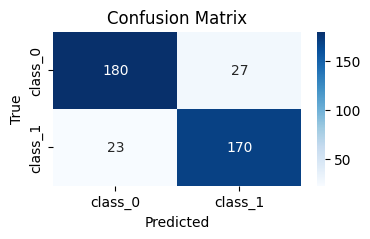

{'eval_loss': 0.35587456822395325, 'eval_accuracy': 0.875, 'eval_f1': 0.8750312695434646, 'eval_precision': 0.8752375534495261, 'eval_recall': 0.875, 'eval_runtime': 3.8281, 'eval_samples_per_second': 104.491, 'eval_steps_per_second': 6.531, 'epoch': 4.5}
{'loss': 0.1823, 'grad_norm': 10.457694053649902, 'learning_rate': 0.0001, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

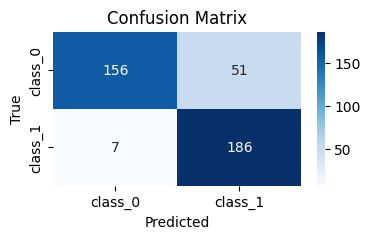

{'eval_loss': 0.4968574643135071, 'eval_accuracy': 0.855, 'eval_f1': 0.8537969830295412, 'eval_precision': 0.8739469596955813, 'eval_recall': 0.855, 'eval_runtime': 3.8255, 'eval_samples_per_second': 104.562, 'eval_steps_per_second': 6.535, 'epoch': 5.0}
{'loss': 0.1562, 'grad_norm': 6.056629657745361, 'learning_rate': 9e-05, 'epoch': 5.5}


  0%|          | 0/25 [00:00<?, ?it/s]

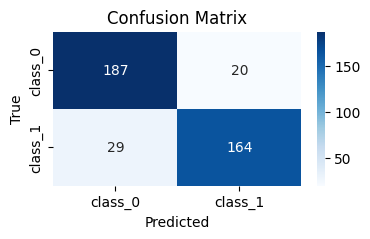

{'eval_loss': 0.33414214849472046, 'eval_accuracy': 0.8775, 'eval_f1': 0.8773409898978498, 'eval_precision': 0.8780751811594203, 'eval_recall': 0.8775, 'eval_runtime': 3.8047, 'eval_samples_per_second': 105.132, 'eval_steps_per_second': 6.571, 'epoch': 5.5}
{'loss': 0.1309, 'grad_norm': 0.12198850512504578, 'learning_rate': 8e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

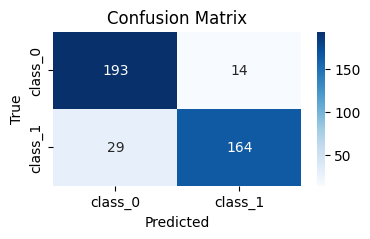

{'eval_loss': 0.4335147738456726, 'eval_accuracy': 0.8925, 'eval_f1': 0.8922061900363788, 'eval_precision': 0.8944492104464016, 'eval_recall': 0.8925, 'eval_runtime': 3.5274, 'eval_samples_per_second': 113.399, 'eval_steps_per_second': 7.087, 'epoch': 6.0}
{'loss': 0.0962, 'grad_norm': 2.1415159702301025, 'learning_rate': 7e-05, 'epoch': 6.5}


  0%|          | 0/25 [00:00<?, ?it/s]

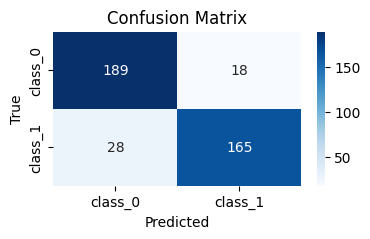

{'eval_loss': 0.4197416305541992, 'eval_accuracy': 0.885, 'eval_f1': 0.8848268767563228, 'eval_precision': 0.8857667900581703, 'eval_recall': 0.885, 'eval_runtime': 3.9214, 'eval_samples_per_second': 102.006, 'eval_steps_per_second': 6.375, 'epoch': 6.5}
{'loss': 0.0865, 'grad_norm': 0.1331290304660797, 'learning_rate': 6e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

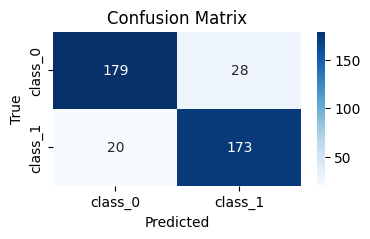

{'eval_loss': 0.40969735383987427, 'eval_accuracy': 0.88, 'eval_f1': 0.8800360081018229, 'eval_precision': 0.8807760194004851, 'eval_recall': 0.88, 'eval_runtime': 3.9883, 'eval_samples_per_second': 100.294, 'eval_steps_per_second': 6.268, 'epoch': 7.0}
{'loss': 0.0768, 'grad_norm': 0.1718551069498062, 'learning_rate': 5e-05, 'epoch': 7.5}


  0%|          | 0/25 [00:00<?, ?it/s]

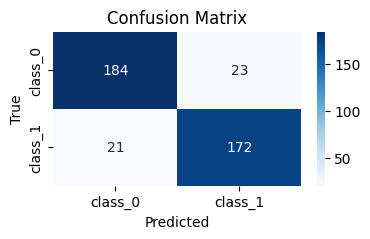

{'eval_loss': 0.3975236415863037, 'eval_accuracy': 0.89, 'eval_f1': 0.890016514863377, 'eval_precision': 0.8900775484677925, 'eval_recall': 0.89, 'eval_runtime': 4.1018, 'eval_samples_per_second': 97.519, 'eval_steps_per_second': 6.095, 'epoch': 7.5}
{'loss': 0.0557, 'grad_norm': 2.4412879943847656, 'learning_rate': 4e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

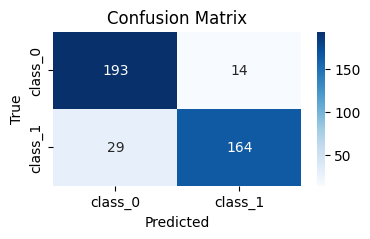

{'eval_loss': 0.45049744844436646, 'eval_accuracy': 0.8925, 'eval_f1': 0.8922061900363788, 'eval_precision': 0.8944492104464016, 'eval_recall': 0.8925, 'eval_runtime': 3.9788, 'eval_samples_per_second': 100.534, 'eval_steps_per_second': 6.283, 'epoch': 8.0}
{'loss': 0.0639, 'grad_norm': 6.595742225646973, 'learning_rate': 3e-05, 'epoch': 8.5}


  0%|          | 0/25 [00:00<?, ?it/s]

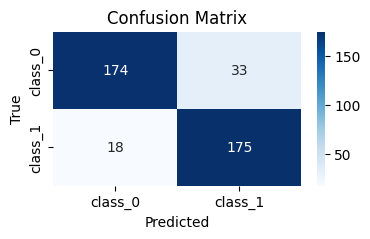

{'eval_loss': 0.4590242803096771, 'eval_accuracy': 0.8725, 'eval_f1': 0.8724880468002926, 'eval_precision': 0.8749338942307694, 'eval_recall': 0.8725, 'eval_runtime': 4.0116, 'eval_samples_per_second': 99.711, 'eval_steps_per_second': 6.232, 'epoch': 8.5}
{'loss': 0.0181, 'grad_norm': 1.0261931419372559, 'learning_rate': 2e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

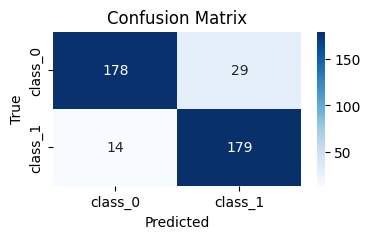

{'eval_loss': 0.4769990146160126, 'eval_accuracy': 0.8925, 'eval_f1': 0.8924899218120115, 'eval_precision': 0.8949939903846155, 'eval_recall': 0.8925, 'eval_runtime': 3.9797, 'eval_samples_per_second': 100.511, 'eval_steps_per_second': 6.282, 'epoch': 9.0}
{'loss': 0.03, 'grad_norm': 0.6428200006484985, 'learning_rate': 1e-05, 'epoch': 9.5}


  0%|          | 0/25 [00:00<?, ?it/s]

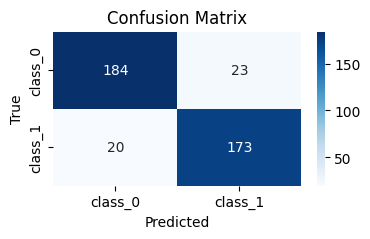

{'eval_loss': 0.44085562229156494, 'eval_accuracy': 0.8925, 'eval_f1': 0.8925221886551705, 'eval_precision': 0.8926448079231694, 'eval_recall': 0.8925, 'eval_runtime': 4.0074, 'eval_samples_per_second': 99.815, 'eval_steps_per_second': 6.238, 'epoch': 9.5}
{'loss': 0.0252, 'grad_norm': 1.0802825689315796, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

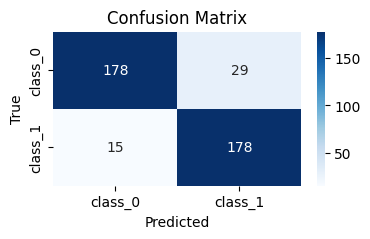

{'eval_loss': 0.4809837341308594, 'eval_accuracy': 0.89, 'eval_f1': 0.89, 'eval_precision': 0.8921831743886262, 'eval_recall': 0.89, 'eval_runtime': 3.9325, 'eval_samples_per_second': 101.716, 'eval_steps_per_second': 6.357, 'epoch': 10.0}
{'train_runtime': 398.197, 'train_samples_per_second': 40.181, 'train_steps_per_second': 2.511, 'train_loss': 0.22257549279928207, 'epoch': 10.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

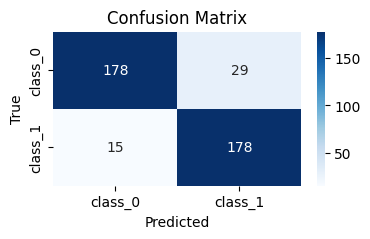

  0%|          | 0/50 [00:00<?, ?it/s]

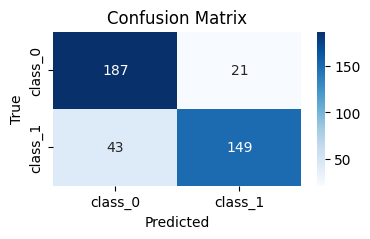

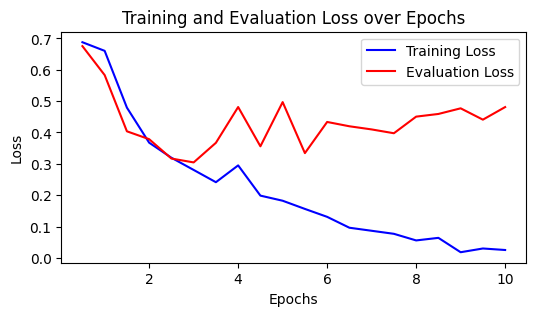

eval/accuracy,▁▆▆▇▇█▇▇█▇███████████▇
eval/f1,▁▆▇▇▇█▇▇█▇███████████▇
eval/loss,▇▆▃▂▁▁▂▄▂▄▁▃▃▃▃▃▄▄▃▄▄█
eval/precision,▁▅▇▇▇█▇▇▇▇██████▇████▇
eval/recall,▁▆▆▇▇█▇▇█▇███████████▇
eval/runtime,▄▃▄▄▄▄▄▄▃▃▃▁▄▄▅▄▄▄▄▄██
eval/samples_per_second,▅▅▅▅▅▅▅▅▆▆▆█▅▅▄▅▄▅▄▅▁▁
eval/steps_per_second,▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁██
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████▁▁▁
train/grad_norm,▃▂▇▃▃▂▁▄▃█▅▁▂▁▁▃▅▂▁▂


Evaluation Results for seed 42:
{'eval_accuracy': 0.89,
 'eval_f1': 0.89,
 'eval_loss': 0.4809839725494385,
 'eval_precision': 0.8921831743886262,
 'eval_recall': 0.89,
 'eval_runtime': 4.6064,
 'eval_samples_per_second': 86.835,
 'eval_steps_per_second': 10.854}
Test Results for seed 42:
{'eval_accuracy': 0.84,
 'eval_f1': 0.839156386387144,
 'eval_loss': 0.7317633032798767,
 'eval_precision': 0.8434884910485934,
 'eval_recall': 0.84,
 'eval_runtime': 4.5922,
 'eval_samples_per_second': 87.104,
 'eval_steps_per_second': 10.888}
Setting seed to: 10


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
SDA_SG_invLora_stack     lora                294,912       0.269       1       1
SDA_mlm_inv_G            bottleneck        7,387,776       6.748       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8897468 || all params: 118379708 || trainable%: 7.516041516169309


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.691, 'grad_norm': 2.633916139602661, 'learning_rate': 1e-05, 'epoch': 0.5}


  0%|          | 0/25 [00:00<?, ?it/s]

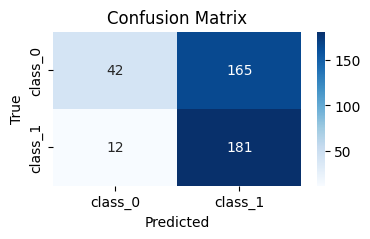

{'eval_loss': 0.6785771250724792, 'eval_accuracy': 0.5575, 'eval_f1': 0.4906055274774486, 'eval_precision': 0.6549060693641618, 'eval_recall': 0.5575, 'eval_runtime': 4.0022, 'eval_samples_per_second': 99.945, 'eval_steps_per_second': 6.247, 'epoch': 0.5}
{'loss': 0.6665, 'grad_norm': 1.8258213996887207, 'learning_rate': 2e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

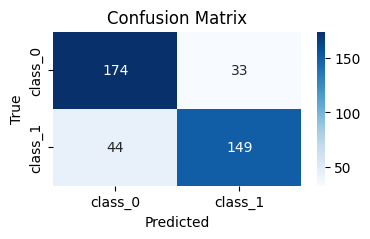

{'eval_loss': 0.6008889079093933, 'eval_accuracy': 0.8075, 'eval_f1': 0.8071678431372549, 'eval_precision': 0.8080641949793326, 'eval_recall': 0.8075, 'eval_runtime': 3.9891, 'eval_samples_per_second': 100.274, 'eval_steps_per_second': 6.267, 'epoch': 1.0}
{'loss': 0.493, 'grad_norm': 7.462443828582764, 'learning_rate': 3e-05, 'epoch': 1.5}


  0%|          | 0/25 [00:00<?, ?it/s]

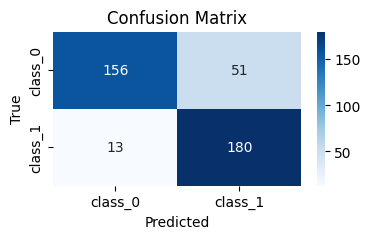

{'eval_loss': 0.3754372298717499, 'eval_accuracy': 0.84, 'eval_f1': 0.839084704937776, 'eval_precision': 0.8536663336663338, 'eval_recall': 0.84, 'eval_runtime': 4.0006, 'eval_samples_per_second': 99.985, 'eval_steps_per_second': 6.249, 'epoch': 1.5}
{'loss': 0.3725, 'grad_norm': 3.354537010192871, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

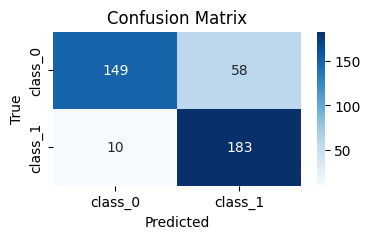

{'eval_loss': 0.3854732811450958, 'eval_accuracy': 0.83, 'eval_f1': 0.8282533806753796, 'eval_precision': 0.8513324982384717, 'eval_recall': 0.83, 'eval_runtime': 3.9885, 'eval_samples_per_second': 100.287, 'eval_steps_per_second': 6.268, 'epoch': 2.0}
{'loss': 0.3208, 'grad_norm': 2.8379621505737305, 'learning_rate': 5e-05, 'epoch': 2.5}


  0%|          | 0/25 [00:00<?, ?it/s]

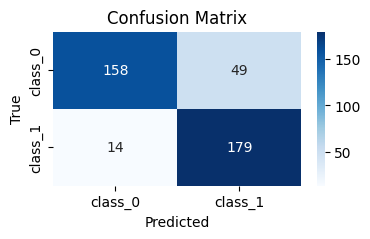

{'eval_loss': 0.340799480676651, 'eval_accuracy': 0.8425, 'eval_f1': 0.8417744846733811, 'eval_precision': 0.8541827315381476, 'eval_recall': 0.8425, 'eval_runtime': 4.0309, 'eval_samples_per_second': 99.234, 'eval_steps_per_second': 6.202, 'epoch': 2.5}
{'loss': 0.2917, 'grad_norm': 1.7807731628417969, 'learning_rate': 6e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

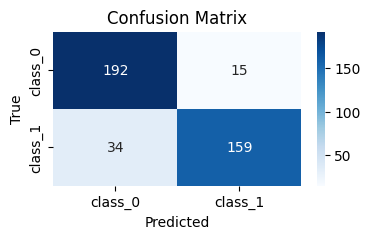

{'eval_loss': 0.30024024844169617, 'eval_accuracy': 0.8775, 'eval_f1': 0.8770166634153708, 'eval_precision': 0.8805511901129082, 'eval_recall': 0.8775, 'eval_runtime': 3.9811, 'eval_samples_per_second': 100.474, 'eval_steps_per_second': 6.28, 'epoch': 3.0}
{'loss': 0.2513, 'grad_norm': 1.4481879472732544, 'learning_rate': 7e-05, 'epoch': 3.5}


  0%|          | 0/25 [00:00<?, ?it/s]

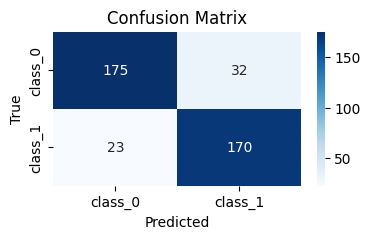

{'eval_loss': 0.3539389669895172, 'eval_accuracy': 0.8625, 'eval_f1': 0.8625386779184248, 'eval_precision': 0.8634507200720072, 'eval_recall': 0.8625, 'eval_runtime': 4.0065, 'eval_samples_per_second': 99.837, 'eval_steps_per_second': 6.24, 'epoch': 3.5}
{'loss': 0.2536, 'grad_norm': 6.674170970916748, 'learning_rate': 8e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

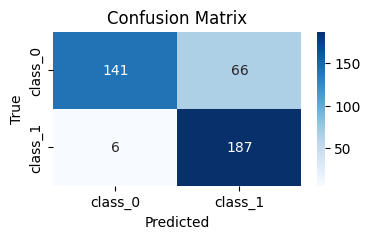

{'eval_loss': 0.5048839449882507, 'eval_accuracy': 0.82, 'eval_f1': 0.81685338603025, 'eval_precision': 0.8530079858030168, 'eval_recall': 0.82, 'eval_runtime': 3.9505, 'eval_samples_per_second': 101.254, 'eval_steps_per_second': 6.328, 'epoch': 4.0}
{'loss': 0.1827, 'grad_norm': 0.20364056527614594, 'learning_rate': 9e-05, 'epoch': 4.5}


  0%|          | 0/25 [00:00<?, ?it/s]

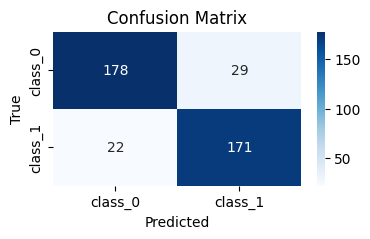

{'eval_loss': 0.36521950364112854, 'eval_accuracy': 0.8725, 'eval_f1': 0.8725390588367687, 'eval_precision': 0.8731125, 'eval_recall': 0.8725, 'eval_runtime': 3.969, 'eval_samples_per_second': 100.781, 'eval_steps_per_second': 6.299, 'epoch': 4.5}
{'loss': 0.2029, 'grad_norm': 4.326681137084961, 'learning_rate': 0.0001, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

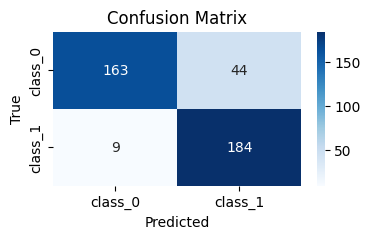

{'eval_loss': 0.42361128330230713, 'eval_accuracy': 0.8675, 'eval_f1': 0.8668896458363363, 'eval_precision': 0.8798074765401875, 'eval_recall': 0.8675, 'eval_runtime': 3.9745, 'eval_samples_per_second': 100.641, 'eval_steps_per_second': 6.29, 'epoch': 5.0}
{'loss': 0.1656, 'grad_norm': 4.470626354217529, 'learning_rate': 9e-05, 'epoch': 5.5}


  0%|          | 0/25 [00:00<?, ?it/s]

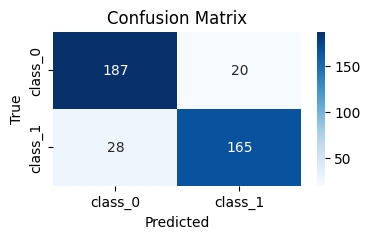

{'eval_loss': 0.345071017742157, 'eval_accuracy': 0.88, 'eval_f1': 0.8798675994884525, 'eval_precision': 0.8804424890006285, 'eval_recall': 0.88, 'eval_runtime': 3.9877, 'eval_samples_per_second': 100.308, 'eval_steps_per_second': 6.269, 'epoch': 5.5}
{'loss': 0.1272, 'grad_norm': 14.194806098937988, 'learning_rate': 8e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

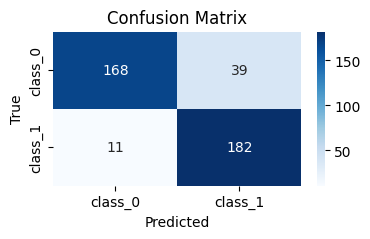

{'eval_loss': 0.4531712234020233, 'eval_accuracy': 0.875, 'eval_f1': 0.8746933743836199, 'eval_precision': 0.8830512651988169, 'eval_recall': 0.875, 'eval_runtime': 3.9912, 'eval_samples_per_second': 100.222, 'eval_steps_per_second': 6.264, 'epoch': 6.0}
{'loss': 0.0736, 'grad_norm': 2.4946799278259277, 'learning_rate': 7e-05, 'epoch': 6.5}


  0%|          | 0/25 [00:00<?, ?it/s]

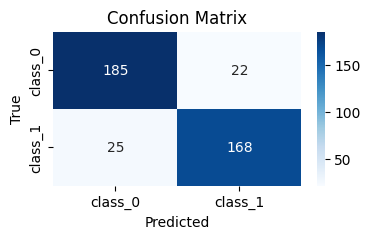

{'eval_loss': 0.4222056567668915, 'eval_accuracy': 0.8825, 'eval_f1': 0.8824624791028797, 'eval_precision': 0.8825244360902255, 'eval_recall': 0.8825, 'eval_runtime': 3.9468, 'eval_samples_per_second': 101.348, 'eval_steps_per_second': 6.334, 'epoch': 6.5}
{'loss': 0.0901, 'grad_norm': 0.0883457288146019, 'learning_rate': 6e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

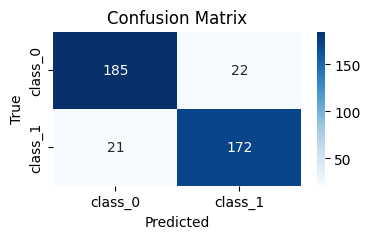

{'eval_loss': 0.4138786196708679, 'eval_accuracy': 0.8925, 'eval_f1': 0.8925087436104384, 'eval_precision': 0.8925286507857072, 'eval_recall': 0.8925, 'eval_runtime': 3.9937, 'eval_samples_per_second': 100.158, 'eval_steps_per_second': 6.26, 'epoch': 7.0}
{'loss': 0.0779, 'grad_norm': 0.43303462862968445, 'learning_rate': 5e-05, 'epoch': 7.5}


  0%|          | 0/25 [00:00<?, ?it/s]

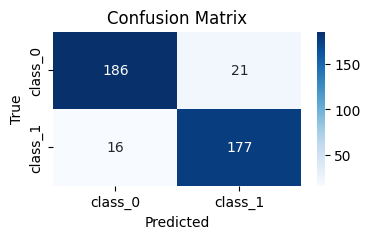

{'eval_loss': 0.41954100131988525, 'eval_accuracy': 0.9075, 'eval_f1': 0.9075260288020811, 'eval_precision': 0.9078356585658566, 'eval_recall': 0.9075, 'eval_runtime': 3.9775, 'eval_samples_per_second': 100.566, 'eval_steps_per_second': 6.285, 'epoch': 7.5}
{'loss': 0.0729, 'grad_norm': 23.95672035217285, 'learning_rate': 4e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

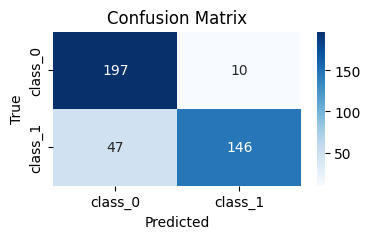

{'eval_loss': 0.601822555065155, 'eval_accuracy': 0.8575, 'eval_f1': 0.8557916187523428, 'eval_precision': 0.8693881357713326, 'eval_recall': 0.8575, 'eval_runtime': 3.9818, 'eval_samples_per_second': 100.456, 'eval_steps_per_second': 6.278, 'epoch': 8.0}
{'loss': 0.0534, 'grad_norm': 2.1942811012268066, 'learning_rate': 3e-05, 'epoch': 8.5}


  0%|          | 0/25 [00:00<?, ?it/s]

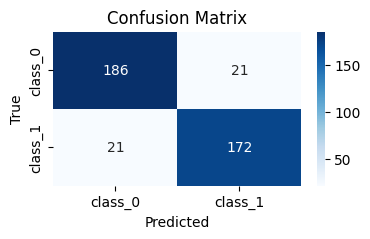

{'eval_loss': 0.4614880383014679, 'eval_accuracy': 0.895, 'eval_f1': 0.895, 'eval_precision': 0.895, 'eval_recall': 0.895, 'eval_runtime': 3.9548, 'eval_samples_per_second': 101.144, 'eval_steps_per_second': 6.321, 'epoch': 8.5}
{'loss': 0.0147, 'grad_norm': 13.07425594329834, 'learning_rate': 2e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

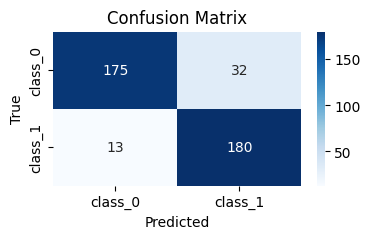

{'eval_loss': 0.5316601991653442, 'eval_accuracy': 0.8875, 'eval_f1': 0.8874331926863573, 'eval_precision': 0.8913852368526696, 'eval_recall': 0.8875, 'eval_runtime': 3.9949, 'eval_samples_per_second': 100.127, 'eval_steps_per_second': 6.258, 'epoch': 9.0}
{'loss': 0.0188, 'grad_norm': 0.06487599015235901, 'learning_rate': 1e-05, 'epoch': 9.5}


  0%|          | 0/25 [00:00<?, ?it/s]

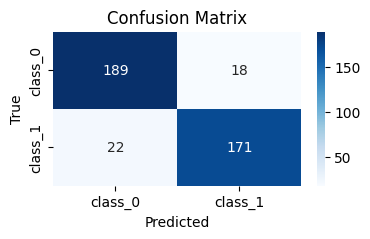

{'eval_loss': 0.5137711763381958, 'eval_accuracy': 0.9, 'eval_f1': 0.8999549086900974, 'eval_precision': 0.900090273076055, 'eval_recall': 0.9, 'eval_runtime': 3.9766, 'eval_samples_per_second': 100.587, 'eval_steps_per_second': 6.287, 'epoch': 9.5}
{'loss': 0.0259, 'grad_norm': 0.04226699098944664, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

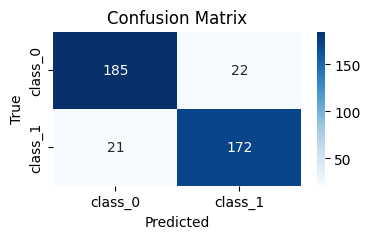

{'eval_loss': 0.49686911702156067, 'eval_accuracy': 0.8925, 'eval_f1': 0.8925087436104384, 'eval_precision': 0.8925286507857072, 'eval_recall': 0.8925, 'eval_runtime': 3.9635, 'eval_samples_per_second': 100.92, 'eval_steps_per_second': 6.308, 'epoch': 10.0}
{'train_runtime': 402.1477, 'train_samples_per_second': 39.786, 'train_steps_per_second': 2.487, 'train_loss': 0.2223007509112358, 'epoch': 10.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

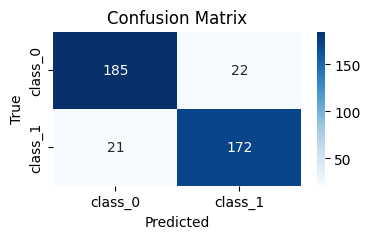

  0%|          | 0/50 [00:00<?, ?it/s]

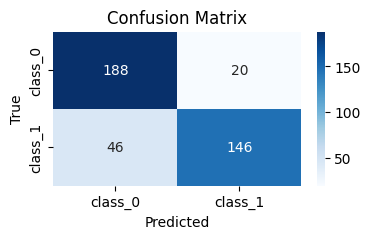

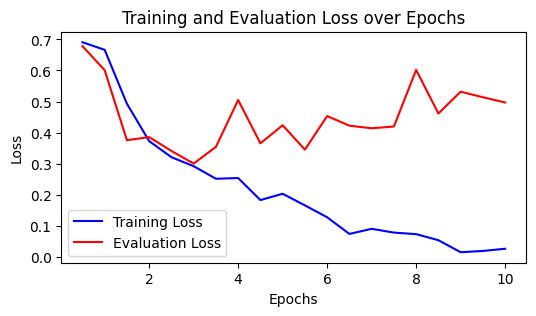

eval/accuracy,▁▆▇▆▇▇▇▆▇▇▇▇▇██▇█████▇
eval/f1,▁▆▇▇▇▇▇▆▇▇█▇███▇█████▇
eval/loss,▆▅▂▂▂▁▂▄▂▃▂▃▃▂▃▅▃▄▄▄▄█
eval/precision,▁▅▇▆▇▇▇▆▇▇▇▇▇██▇█████▆
eval/recall,▁▆▇▆▇▇▇▆▇▇▇▇▇██▇█████▇
eval/runtime,▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁██
eval/samples_per_second,▇▇▇▇▇█▇████▇█▇███▇██▁▁
eval/steps_per_second,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████▁▁▁
train/grad_norm,▂▂▃▂▂▂▁▃▁▂▂▅▂▁▁█▂▅▁▁


Evaluation Results for seed 10:
{'eval_accuracy': 0.8925,
 'eval_f1': 0.8925087436104384,
 'eval_loss': 0.49686911702156067,
 'eval_precision': 0.8925286507857072,
 'eval_recall': 0.8925,
 'eval_runtime': 4.5938,
 'eval_samples_per_second': 87.075,
 'eval_steps_per_second': 10.884}
Test Results for seed 10:
{'eval_accuracy': 0.835,
 'eval_f1': 0.8338613210647386,
 'eval_loss': 0.835113525390625,
 'eval_precision': 0.8399464524765731,
 'eval_recall': 0.835,
 'eval_runtime': 4.6179,
 'eval_samples_per_second': 86.619,
 'eval_steps_per_second': 10.827}
Setting seed to: 100


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
SDA_SG_invLora_stack     lora                294,912       0.269       1       1
SDA_mlm_inv_G            bottleneck        7,387,776       6.748       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8897468 || all params: 118379708 || trainable%: 7.516041516169309


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.6964, 'grad_norm': 2.54205322265625, 'learning_rate': 1e-05, 'epoch': 0.5}


  0%|          | 0/25 [00:00<?, ?it/s]

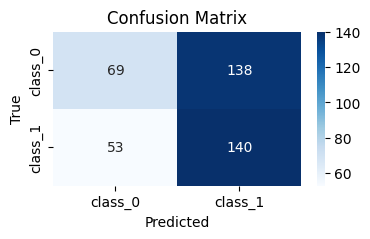

{'eval_loss': 0.688386082649231, 'eval_accuracy': 0.5225, 'eval_f1': 0.503903387347621, 'eval_precision': 0.5356700377402995, 'eval_recall': 0.5225, 'eval_runtime': 3.8217, 'eval_samples_per_second': 104.666, 'eval_steps_per_second': 6.542, 'epoch': 0.5}
{'loss': 0.6779, 'grad_norm': 1.7726714611053467, 'learning_rate': 2e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

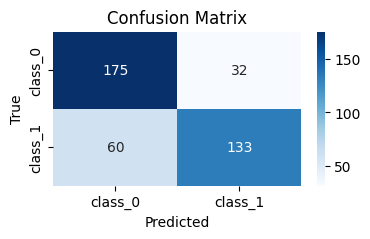

{'eval_loss': 0.6366869211196899, 'eval_accuracy': 0.77, 'eval_f1': 0.768290654465482, 'eval_precision': 0.7742965828497742, 'eval_recall': 0.77, 'eval_runtime': 3.8122, 'eval_samples_per_second': 104.927, 'eval_steps_per_second': 6.558, 'epoch': 1.0}
{'loss': 0.5291, 'grad_norm': 7.251188278198242, 'learning_rate': 3e-05, 'epoch': 1.5}


  0%|          | 0/25 [00:00<?, ?it/s]

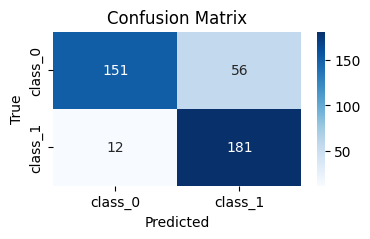

{'eval_loss': 0.39180317521095276, 'eval_accuracy': 0.83, 'eval_f1': 0.8285895663104965, 'eval_precision': 0.8478934016722321, 'eval_recall': 0.83, 'eval_runtime': 3.8224, 'eval_samples_per_second': 104.647, 'eval_steps_per_second': 6.54, 'epoch': 1.5}
{'loss': 0.3794, 'grad_norm': 4.2285261154174805, 'learning_rate': 4e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

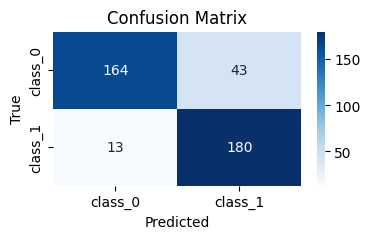

{'eval_loss': 0.33613792061805725, 'eval_accuracy': 0.86, 'eval_f1': 0.8595793269230769, 'eval_precision': 0.8689534088318005, 'eval_recall': 0.86, 'eval_runtime': 3.938, 'eval_samples_per_second': 101.574, 'eval_steps_per_second': 6.348, 'epoch': 2.0}
{'loss': 0.315, 'grad_norm': 3.791767120361328, 'learning_rate': 5e-05, 'epoch': 2.5}


  0%|          | 0/25 [00:00<?, ?it/s]

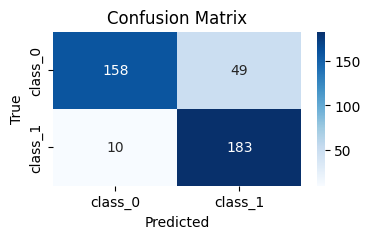

{'eval_loss': 0.3452538251876831, 'eval_accuracy': 0.8525, 'eval_f1': 0.8515976470588233, 'eval_precision': 0.8672891009852216, 'eval_recall': 0.8525, 'eval_runtime': 3.9883, 'eval_samples_per_second': 100.294, 'eval_steps_per_second': 6.268, 'epoch': 2.5}
{'loss': 0.3176, 'grad_norm': 1.3674085140228271, 'learning_rate': 6e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

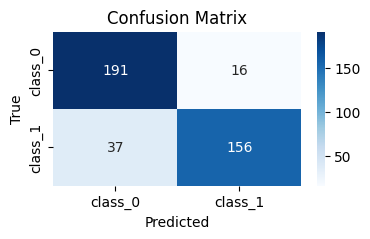

{'eval_loss': 0.30798378586769104, 'eval_accuracy': 0.8675, 'eval_f1': 0.8668866320264524, 'eval_precision': 0.8711360159118726, 'eval_recall': 0.8675, 'eval_runtime': 3.887, 'eval_samples_per_second': 102.908, 'eval_steps_per_second': 6.432, 'epoch': 3.0}
{'loss': 0.2619, 'grad_norm': 1.8936363458633423, 'learning_rate': 7e-05, 'epoch': 3.5}


  0%|          | 0/25 [00:00<?, ?it/s]

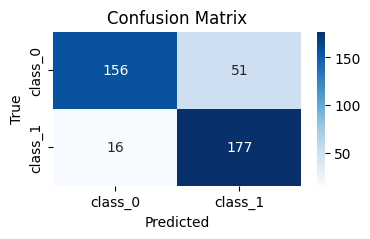

{'eval_loss': 0.40659546852111816, 'eval_accuracy': 0.8325, 'eval_f1': 0.8317284202081987, 'eval_precision': 0.8439328335373317, 'eval_recall': 0.8325, 'eval_runtime': 3.9974, 'eval_samples_per_second': 100.065, 'eval_steps_per_second': 6.254, 'epoch': 3.5}
{'loss': 0.2779, 'grad_norm': 3.983443021774292, 'learning_rate': 8e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

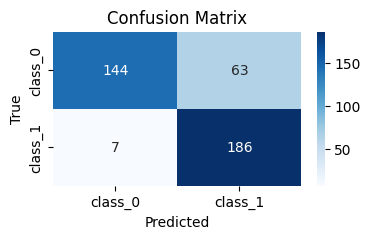

{'eval_loss': 0.44512078166007996, 'eval_accuracy': 0.825, 'eval_f1': 0.8223988220126899, 'eval_precision': 0.8539316205218224, 'eval_recall': 0.825, 'eval_runtime': 3.9852, 'eval_samples_per_second': 100.373, 'eval_steps_per_second': 6.273, 'epoch': 4.0}
{'loss': 0.1866, 'grad_norm': 1.2142236232757568, 'learning_rate': 9e-05, 'epoch': 4.5}


  0%|          | 0/25 [00:00<?, ?it/s]

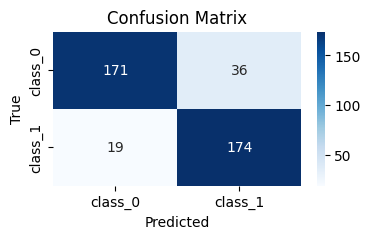

{'eval_loss': 0.3871719241142273, 'eval_accuracy': 0.8625, 'eval_f1': 0.8624561694095293, 'eval_precision': 0.8655357142857143, 'eval_recall': 0.8625, 'eval_runtime': 3.9858, 'eval_samples_per_second': 100.356, 'eval_steps_per_second': 6.272, 'epoch': 4.5}
{'loss': 0.1734, 'grad_norm': 5.187779426574707, 'learning_rate': 0.0001, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

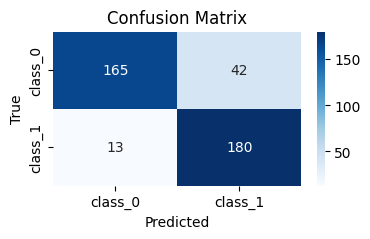

{'eval_loss': 0.4049278199672699, 'eval_accuracy': 0.8625, 'eval_f1': 0.8621256454388984, 'eval_precision': 0.8709212723959915, 'eval_recall': 0.8625, 'eval_runtime': 3.967, 'eval_samples_per_second': 100.831, 'eval_steps_per_second': 6.302, 'epoch': 5.0}
{'loss': 0.1857, 'grad_norm': 1.9749070405960083, 'learning_rate': 9e-05, 'epoch': 5.5}


  0%|          | 0/25 [00:00<?, ?it/s]

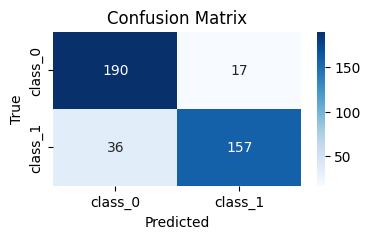

{'eval_loss': 0.341991126537323, 'eval_accuracy': 0.8675, 'eval_f1': 0.866977207367646, 'eval_precision': 0.8704255670837148, 'eval_recall': 0.8675, 'eval_runtime': 3.9686, 'eval_samples_per_second': 100.792, 'eval_steps_per_second': 6.299, 'epoch': 5.5}
{'loss': 0.1488, 'grad_norm': 7.082027912139893, 'learning_rate': 8e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

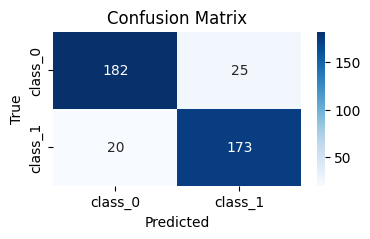

{'eval_loss': 0.3506793975830078, 'eval_accuracy': 0.8875, 'eval_f1': 0.8875316566511796, 'eval_precision': 0.8878406590659066, 'eval_recall': 0.8875, 'eval_runtime': 3.9259, 'eval_samples_per_second': 101.887, 'eval_steps_per_second': 6.368, 'epoch': 6.0}
{'loss': 0.0805, 'grad_norm': 3.2974255084991455, 'learning_rate': 7e-05, 'epoch': 6.5}


  0%|          | 0/25 [00:00<?, ?it/s]

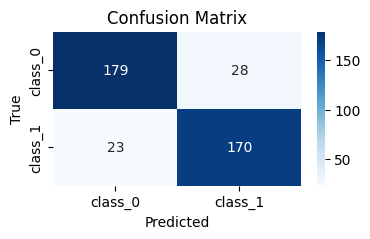

{'eval_loss': 0.48015496134757996, 'eval_accuracy': 0.8725, 'eval_f1': 0.8725358775380037, 'eval_precision': 0.872844409440944, 'eval_recall': 0.8725, 'eval_runtime': 3.9348, 'eval_samples_per_second': 101.656, 'eval_steps_per_second': 6.354, 'epoch': 6.5}
{'loss': 0.0757, 'grad_norm': 0.19318541884422302, 'learning_rate': 6e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

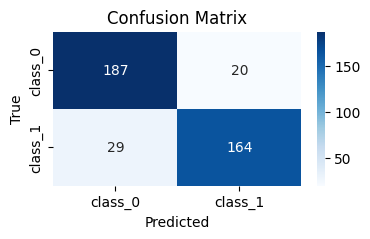

{'eval_loss': 0.4194832742214203, 'eval_accuracy': 0.8775, 'eval_f1': 0.8773409898978498, 'eval_precision': 0.8780751811594203, 'eval_recall': 0.8775, 'eval_runtime': 3.972, 'eval_samples_per_second': 100.705, 'eval_steps_per_second': 6.294, 'epoch': 7.0}
{'loss': 0.0762, 'grad_norm': 0.14549532532691956, 'learning_rate': 5e-05, 'epoch': 7.5}


  0%|          | 0/25 [00:00<?, ?it/s]

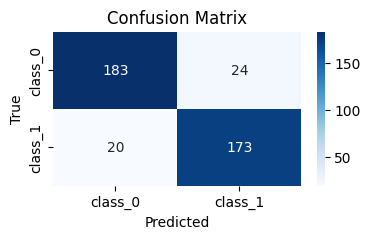

{'eval_loss': 0.4385402798652649, 'eval_accuracy': 0.89, 'eval_f1': 0.8900275171982489, 'eval_precision': 0.8902330524367983, 'eval_recall': 0.89, 'eval_runtime': 3.9891, 'eval_samples_per_second': 100.272, 'eval_steps_per_second': 6.267, 'epoch': 7.5}
{'loss': 0.0604, 'grad_norm': 27.641572952270508, 'learning_rate': 4e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

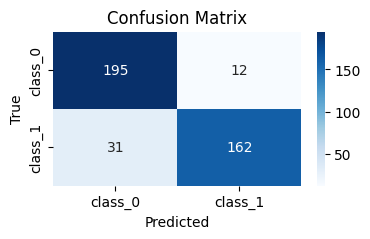

{'eval_loss': 0.4937876760959625, 'eval_accuracy': 0.8925, 'eval_f1': 0.8920758474869581, 'eval_precision': 0.8957396246566981, 'eval_recall': 0.8925, 'eval_runtime': 3.9622, 'eval_samples_per_second': 100.954, 'eval_steps_per_second': 6.31, 'epoch': 8.0}
{'loss': 0.0646, 'grad_norm': 4.727696895599365, 'learning_rate': 3e-05, 'epoch': 8.5}


  0%|          | 0/25 [00:00<?, ?it/s]

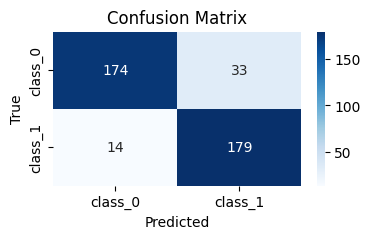

{'eval_loss': 0.4426039159297943, 'eval_accuracy': 0.8825, 'eval_f1': 0.8824302234724175, 'eval_precision': 0.8863566338819752, 'eval_recall': 0.8825, 'eval_runtime': 3.9454, 'eval_samples_per_second': 101.383, 'eval_steps_per_second': 6.336, 'epoch': 8.5}
{'loss': 0.0162, 'grad_norm': 11.841527938842773, 'learning_rate': 2e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

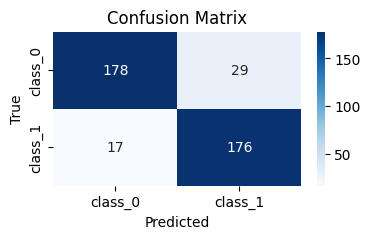

{'eval_loss': 0.49709171056747437, 'eval_accuracy': 0.885, 'eval_f1': 0.8850172504312607, 'eval_precision': 0.8866285178236397, 'eval_recall': 0.885, 'eval_runtime': 3.9194, 'eval_samples_per_second': 102.056, 'eval_steps_per_second': 6.379, 'epoch': 9.0}
{'loss': 0.015, 'grad_norm': 0.08058005571365356, 'learning_rate': 1e-05, 'epoch': 9.5}


  0%|          | 0/25 [00:00<?, ?it/s]

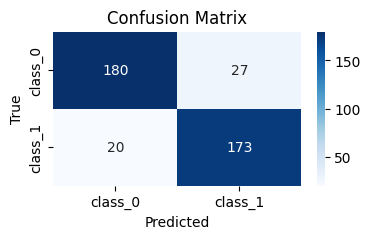

{'eval_loss': 0.4970140755176544, 'eval_accuracy': 0.8825, 'eval_f1': 0.8825359953985908, 'eval_precision': 0.8831125, 'eval_recall': 0.8825, 'eval_runtime': 3.9455, 'eval_samples_per_second': 101.382, 'eval_steps_per_second': 6.336, 'epoch': 9.5}
{'loss': 0.0492, 'grad_norm': 0.04704161733388901, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

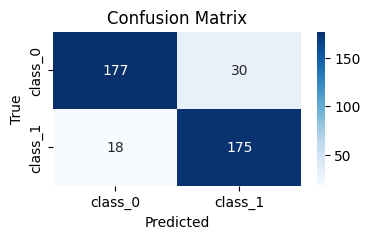

{'eval_loss': 0.5165666341781616, 'eval_accuracy': 0.88, 'eval_f1': 0.8800180004500112, 'eval_precision': 0.8816210131332082, 'eval_recall': 0.88, 'eval_runtime': 3.9539, 'eval_samples_per_second': 101.166, 'eval_steps_per_second': 6.323, 'epoch': 10.0}
{'train_runtime': 398.3657, 'train_samples_per_second': 40.164, 'train_steps_per_second': 2.51, 'train_loss': 0.2293692375421524, 'epoch': 10.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/guest/.cache/pypoetry/virtualenvs/third-experments-xuKQSur9-py3.8/lib/python3.8/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

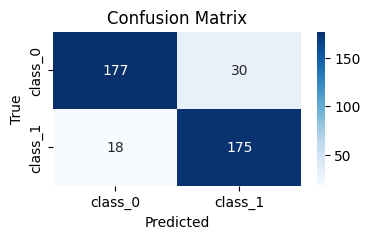

  0%|          | 0/50 [00:00<?, ?it/s]

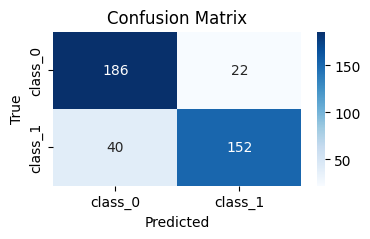

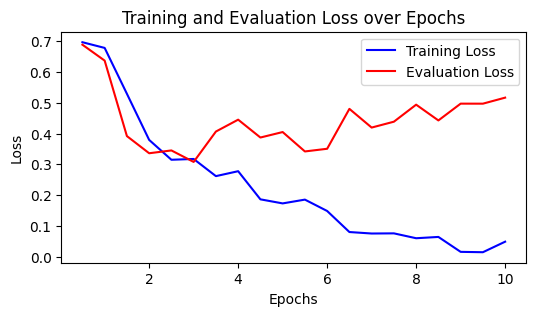

eval/accuracy,▁▆▇▇▇█▇▇▇▇███████████▇
eval/f1,▁▆▇▇▇█▇▇▇▇███████████▇
eval/loss,▆▆▂▁▂▁▂▃▂▂▁▂▃▃▃▄▃▄▄▄▄█
eval/precision,▁▆▇▇▇█▇▇▇████████████▇
eval/recall,▁▆▇▇▇█▇▇▇▇███████████▇
eval/runtime,▁▁▁▂▃▂▃▂▂▂▂▂▂▂▃▂▂▂▂▂██
eval/samples_per_second,███▇▆▇▆▆▆▆▆▇▇▆▆▆▇▇▇▇▁▁
eval/steps_per_second,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████▁▁▁
train/grad_norm,▂▁▃▂▂▁▁▂▁▂▁▃▂▁▁█▂▄▁▁


Evaluation Results for seed 100:
{'eval_accuracy': 0.88,
 'eval_f1': 0.8800180004500112,
 'eval_loss': 0.5165667533874512,
 'eval_precision': 0.8816210131332082,
 'eval_recall': 0.88,
 'eval_runtime': 4.6112,
 'eval_samples_per_second': 86.745,
 'eval_steps_per_second': 10.843}
Test Results for seed 100:
{'eval_accuracy': 0.845,
 'eval_f1': 0.8444028103044496,
 'eval_loss': 0.8002400398254395,
 'eval_precision': 0.8472749465974977,
 'eval_recall': 0.845,
 'eval_runtime': 4.6254,
 'eval_samples_per_second': 86.479,
 'eval_steps_per_second': 10.81}
************
Mean Evaluation Results:
{'eval_accuracy': 0.8875000000000001,
 'eval_f1': 0.8875089146868166,
 'eval_loss': 0.4981399476528168,
 'eval_precision': 0.8887776127691805,
 'eval_recall': 0.8875000000000001,
 'eval_runtime': 4.6038,
 'eval_samples_per_second': 86.88499999999999,
 'eval_steps_per_second': 10.860333333333335}
Mean Test Results:
{'eval_accuracy': 0.8399999999999999,
 'eval_f1': 0.8391401725854442,
 'eval_loss': 0.7890389

In [9]:
seeds = [42, 10, 100]
project_name="SDA_testing_trainer"

adapter_name = "SDA_SG_invLora_stack"
mlm_adapter = "SDA_mlm_inv_G"
all_results = []
source_genre = 'books'
target_genre = 'electronics'
source_dataset, target_dataset = load_and_prepare_datasets(source_genre, target_genre, data_fraction=1)



for seed in seeds:
    eval_results, test_results = train_and_evaluate(project_name, seed, source_dataset, target_dataset, source_genre, target_genre, adapter_name, mlm_adapter)
    all_results.append((eval_results, test_results))
    print(f"Evaluation Results for seed {seed}:")
    pprint(eval_results)
    print(f"Test Results for seed {seed}:")
    pprint(test_results)

mean_eval_results = {key: np.mean([result[0][key] for result in all_results]) for key in all_results[0][0]}
mean_test_results = {key: np.mean([result[1][key] for result in all_results]) for key in all_results[0][1]}
print(f"************")
print(f"Mean Evaluation Results:")
pprint(mean_eval_results)
print(f"Mean Test Results:")
pprint(mean_test_results)
print(f"************")

# Plot the overall performance metrics
for metric in mean_eval_results:
    print(f"Mean Evaluation {metric}: {mean_eval_results[metric]:.4f}")
for metric in mean_test_results:
    print(f"Mean Test {metric}: {mean_test_results[metric]:.4f}")